# code testing
如果换电脑或者换平台运行这个文件，则这个code testing部分可以用来测试各个包的兼容性

In [2]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: None
PATH: D:\Anaconda;D:\Anaconda\Library\mingw-w64\bin;D:\Anaconda\Library\usr\bin;D:\Anaconda\Library\bin;D:\Anaconda\Scripts;D:\Anaconda\bin;D:\Anaconda\condabin;D:\Anaconda;D:\Anaconda\Library\mingw-w64\bin;D:\Anaconda\Library\usr\bin;D:\Anaconda\Library\bin;D:\Anaconda\Scripts;D:\Program Files (x86)\IntelSWTools\compilers_and_libraries_2017.4.210\windows\mpi\intel64\bin;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\intel64_win\mpirt;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\ia32_win\mpirt;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\intel64_win\compiler;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\ia32_win\compiler;D:\SIMULIA\Commands;C:\Program Files\Microsoft MPI\Bin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files (x86)\Windows Kits\8.1\Windows Performance Toolkit;D:\Program Files (x86)\

In [3]:
import keras

我们可以从下面这个例子中知道最新的utils调用方法，传统的from keras.utils.visualize_utils import plot以及from keras.vis_utils import plot的用法已经不再适用于最新版Keras（截止到2023.8.28）,目前可以使用from tensorflow.keras import utils

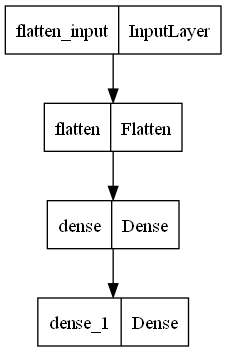

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras import datasets,layers,Sequential,losses,optimizers,utils
import keras
from keras import datasets, models, layers, utils, optimizers, Sequential
 
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0
 
model = Sequential([
    layers.Flatten(input_shape=(28,28)),       # 28*28是一个图片的尺寸
    layers.Dense(128,activation="relu"),
    layers.Dense(10,activation="softmax")    
                            ])
utils.plot_model(model, to_file='model.png')

In [39]:
f = np.linspace(0, 3, 3)
f

array([0. , 1.5, 3. ])

 # 数据导入及预处理


## 注意！！！下面这个单元不要运行

In [1]:
import os

data_dir = 'E:/piloguechin/data'
fname = os.path.join(data_dir, 'd1raw.csv')

f = open(fname, encoding="gb18030")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')    # header of data for each column, shape(1,15) 
lines = lines[1:]    # pure data, shape(420451,1)

print(header)
print(len(lines))
print(len(header))

UnicodeDecodeError: 'gb18030' codec can't decode byte 0xb1 in position 5: illegal multibyte sequence

## 正常导入训练数据
上面这种方法用open()函数打开excel表格，但无法解码数据，就算使用解码库更大的gb18030也不行，选择忽略部分无法解码的错误时直接集体乱码。因此选择xlrd访问文件并定义函数挨个读取数据如下，原始数据被命名为data1

In [1]:
# 训练数据的应变幅值为±0.036
import xlrd

train_path = 'E:/piloguechin/Coderlife/Pilogue/d1raw.csv'
train_sheet = '1d'
def resd_excel(path, sheet):
    wb = xlrd.open_workbook(path)
    sheet = wb.sheet_by_name(sheet)
    dat = []
    for a in range(sheet.nrows):
        cells = sheet.row_values(a)
        dat.append(cells)
    return dat
data1 = resd_excel(train_path, train_sheet)

## 解析数据
在这里训练数据被转化为浮点数，并取名为float_data

In [2]:
import numpy as np

data = np.array(data1)
lines = data.shape[0]
headers = data.shape[1]
print(lines, headers)
float_data = np.zeros((lines, headers))    
for i, line in enumerate(data):
    values = [float(x) for x in data[i]]   
    float_data[i, :] = values
float_data

3000 7


array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [3]:
float_data.shape

(3000, 7)

## 绘制应力曲线

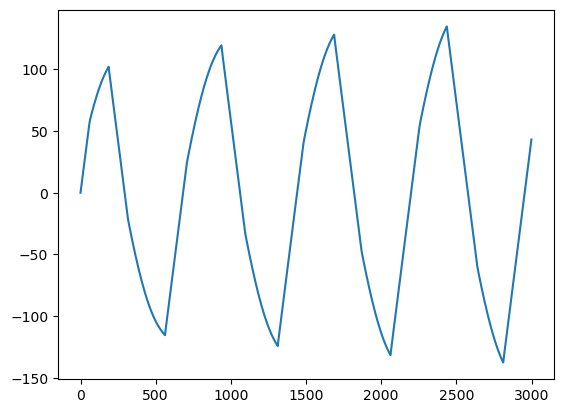

In [4]:
import matplotlib.pyplot as plt

stress = float_data[:, 3 ]
plt.plot(range(len(stress)), stress)
plt.show()

## 标准化
标准化时对全部数据一起操作，但是只使用训练集的平均值和标准差，这样可以防止测试数据泄露给模型

In [5]:
# 对数据进行标准化，减去特征平均值，再除以标准差
mean = float_data[:1800].mean(axis=0)
float_data -= mean
std = float_data[:1800].std(axis=0)
float_data /= std

## 导入测试数据

3000 7


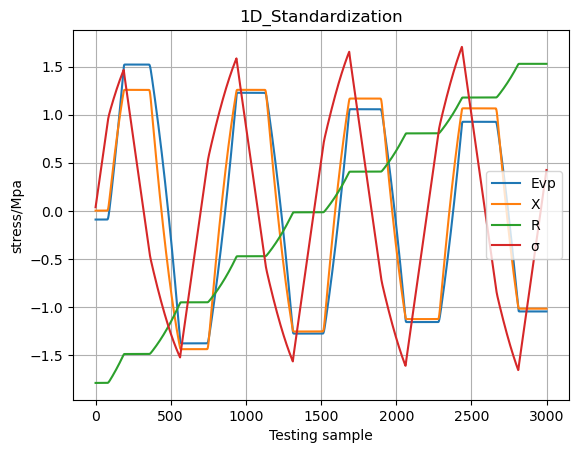

In [6]:
# 最终测试数据应力幅值为±0.025
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 准备测试数据
test_path = 'E:/piloguechin/Coderlife/Pilogue/d1raw_t25.csv'
test_sheet = '1d'
data2 = resd_excel(test_path, test_sheet)
data2

# 解析测试数据
data_t = np.array(data2)
lines_t = data_t.shape[0]
headers_t = data_t.shape[1]
print(lines_t, headers_t)
float_test = np.zeros((lines_t, headers_t))    
for i, line in enumerate(data_t):
    values = [float(x) for x in data_t[i]]   
    float_test[i, :] = values
float_test

# 简单划分
testd1 = float_test[:, :4]
targetsd1 = float_test[:, 4:]

# 标准化数据
scaler = StandardScaler()
testd1 = scaler.fit_transform(testd1)
targetsd1 = scaler.fit_transform(targetsd1)

# 绘制输入特征曲线
plt.plot(testd1[:, 0], label='Evp')
plt.plot(testd1[:, 1], label='X')
plt.plot(testd1[:, 2], label='R')
plt.plot(testd1[:, 3], label='σ')
plt.title("1D_Standardization")
plt.xlabel("Testing sample")
plt.ylabel("stress/Mpa")
plt.grid()
plt.legend()
plt.show()



# 数据划分

## 生成时间序列样本及其目标的生成器
生成结果为一个元组（samples，targets），其中samples是输入数据的一个批量，targets是对应的目标温度数组，参数介绍—— 
data：浮点数数据组成的原始数组，在上一步中被标准化 
lookback：输入数据应该包括过去多少个时间步 
delay：目标应该在未来多少个时间步之后 
min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步，有助于保存一部分数据用于验证，一部分用于测试 
shuffle：是打乱样本，还是按顺序抽取样本 
batch_size：每个批量的样本数 
step：数据采样的周期（单位：时间步），这里设置为1，为的是每2秒抽取75个数据点，利用上每一个数据点（这是一个仅限于大数据量下使用的参数，因为数据很多所以需要间隔取点）。

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=200, step=1):
    if max_index is None:    # 仅对测试生成器用
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:  # dead cycle
        if shuffle:    # randomly pick up each datapoint
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)    # 重复赋值，该值被r11覆盖
        else:  # pick up in order
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))    # 产生一个数列，等差为1，从i开始，到i + batch_size与max_index中比较小的那个
            i += len(rows)    # 更新i值，一开始为r4给的min_index + lookback，之后每进一次主循环就增加一个batch_size，到max_index封顶
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1] - 3))    # D1: batch_size(不封顶时); D2: timesteps; D3: characters(shape[-1]返回该数组最后一维的长度)
        targets = np.zeros((len(rows), data.shape[-1] - 4))    # D1: 长度为batch_size(不封顶时)，用于装载每个batch的目标温度 
        for j, row in  enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices, :4]
            targets[j] = data[rows[j] + delay][4:]
        yield samples, targets

## 准备训练、验证和测试生成器
generator函数实例化三个生成器：一个用于训练，一个用于验证，一个用于测试。每个生成部分分别读取原始数据的不同时间段：训练器读前2,500个时间步，验证器读取随后的1,500步，测试其读取剩下的时间步。

In [8]:
lookback = 375   # 375为1/2个周期，也就是10s
step = 1
delay = 75    # 75为1/10个周期，也就是2s
batch_size = 32

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1800,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=1801,
                    max_index=2400,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,     # test_gen was not used
                     lookback=lookback,
                     delay=delay,
                     min_index=2401,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size)
val_steps = (2500 - 1501 -lookback) // batch_size

test_steps = (len(float_data) - 2501 -lookback) // batch_size

需要注意的是，这里划分出来的数据只是应用于，在一段时间内，导入这段时间内前一段的数据，这个数据既为应变（输入）数据，而应力率（输出）数据并不是同一个时间点内对应的数据，而是延迟一段时间（delay）后的应力率。如果我们将延迟的时间delay设置为0，那么就是一个很常规的输入输出预测，此时就没有给定现有数据而预测下一瞬间数据的功能了。

# 模型定义与评估

## 模型构建
首先搭建网络，通过keras模块的sequential方式组建网络，可通过model.summary()函数看到网络结构和各层网络的节点与超参数个数。同时需要注意的是，这里使用的优化算法为“rmsprop”，这种算法的特性并不是太清楚，也不知道为什么就是找不到书里提供的那个优化算法。。。还是再找找吧

In [9]:
# 模型定义
from keras import models
from keras import layers
from keras import utils

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1] - 3)))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(3))
model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])

model.summary()

#utils.plot_model(model, to_file='Fatten1d.png', show_shapes=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=103,
                              epochs=200,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 4)                 6004      
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 6019 (23.51 KB)
Trainable params: 6019 (23.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12496\1785817044.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


103/103 [==============================] - 1s 3ms/step - loss: 1.0306 - acc: 0.5240 - val_loss: 2.5068 - val_acc: 0.6694
Epoch 2/200
103/103 [==============================] - 0s 2ms/step - loss: 0.8149 - acc: 0.5234 - val_loss: 5.4620 - val_acc: 0.3947
Epoch 3/200
103/103 [==============================] - 0s 2ms/step - loss: 0.7957 - acc: 0.5158 - val_loss: 0.9814 - val_acc: 0.5526
Epoch 4/200
103/103 [==============================] - 0s 2ms/step - loss: 0.7338 - acc: 0.5416 - val_loss: 0.9306 - val_acc: 0.7385
Epoch 5/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6443 - acc: 0.4915 - val_loss: 0.8996 - val_acc: 0.6053
Epoch 6/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6845 - acc: 0.4806 - val_loss: 0.8711 - val_acc: 0.5526
Epoch 7/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6645 - acc: 0.4530 - val_loss: 0.8364 - val_acc: 0.6053
Epoch 8/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6217

103/103 [==============================] - 0s 2ms/step - loss: 0.4052 - acc: 0.6362 - val_loss: 0.4810 - val_acc: 0.6053
Epoch 63/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4296 - acc: 0.6253 - val_loss: 0.4850 - val_acc: 0.5526
Epoch 64/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4190 - acc: 0.6335 - val_loss: 0.4825 - val_acc: 0.6053
Epoch 65/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4060 - acc: 0.6608 - val_loss: 0.4792 - val_acc: 0.6102
Epoch 66/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4241 - acc: 0.6720 - val_loss: 0.4821 - val_acc: 0.5576
Epoch 67/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4154 - acc: 0.7121 - val_loss: 0.4799 - val_acc: 0.6053
Epoch 68/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4099 - acc: 0.6930 - val_loss: 0.4798 - val_acc: 0.6102
Epoch 69/200
103/103 [==============================] - 0s 2ms/step - loss:

103/103 [==============================] - 0s 2ms/step - loss: 0.4256 - acc: 0.6029 - val_loss: 0.4564 - val_acc: 0.6020
Epoch 124/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4034 - acc: 0.6390 - val_loss: 0.4539 - val_acc: 0.6201
Epoch 125/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3911 - acc: 0.6499 - val_loss: 0.4467 - val_acc: 0.6299
Epoch 126/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4258 - acc: 0.6098 - val_loss: 0.4544 - val_acc: 0.5872
Epoch 127/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4091 - acc: 0.6305 - val_loss: 0.4526 - val_acc: 0.6102
Epoch 128/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3976 - acc: 0.6432 - val_loss: 0.4467 - val_acc: 0.6201
Epoch 129/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4143 - acc: 0.6183 - val_loss: 0.4539 - val_acc: 0.6020
Epoch 130/200
103/103 [==============================] - 0s 2ms/step 

Epoch 184/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3944 - acc: 0.7400 - val_loss: 0.4580 - val_acc: 0.3947
Epoch 185/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3801 - acc: 0.7188 - val_loss: 0.4469 - val_acc: 0.3947
Epoch 186/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4192 - acc: 0.7615 - val_loss: 0.4554 - val_acc: 0.4474
Epoch 187/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3996 - acc: 0.7806 - val_loss: 0.4588 - val_acc: 0.3947
Epoch 188/200
103/103 [==============================] - 0s 2ms/step - loss: 0.3840 - acc: 0.7715 - val_loss: 0.4478 - val_acc: 0.3947
Epoch 189/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4151 - acc: 0.7579 - val_loss: 0.4556 - val_acc: 0.4474
Epoch 190/200
103/103 [==============================] - 0s 2ms/step - loss: 0.4037 - acc: 0.7758 - val_loss: 0.4588 - val_acc: 0.3947
Epoch 191/200
103/103 [==============================] 

## 评估模型
分别可以看到损失函数与精度函数

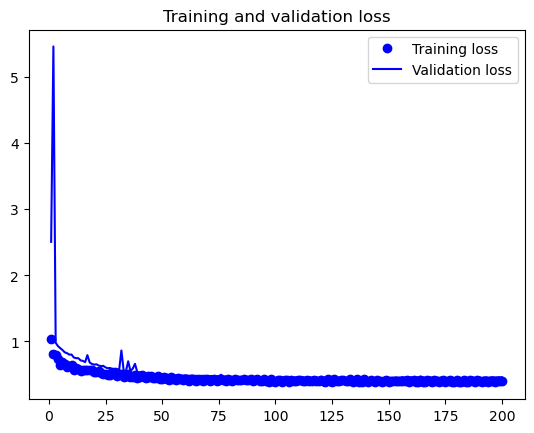

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

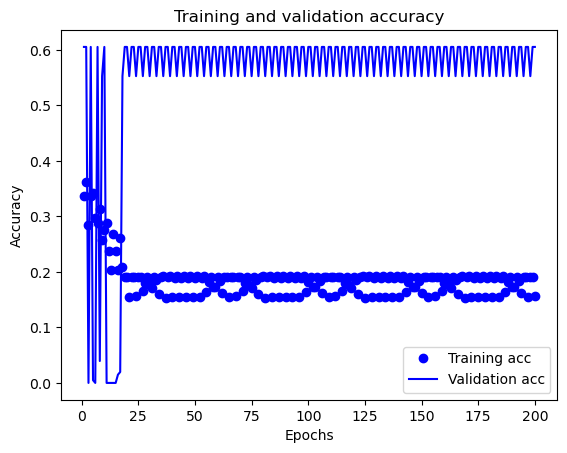

In [11]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 使用模型
这么使用并没有结果。

### 创建最终模型：根据上面得出的运行精度得分确定epoch和batch_size，然后正式用训练集定下模型

In [11]:
# 创建最终模型：根据上面得出的运行精度得分确定epoch和batch_size，然后正式用训练集定下模型
history = model.fit(train_gen, epochs=125, batch_size=16,verbose=0, steps_per_epoch=103)

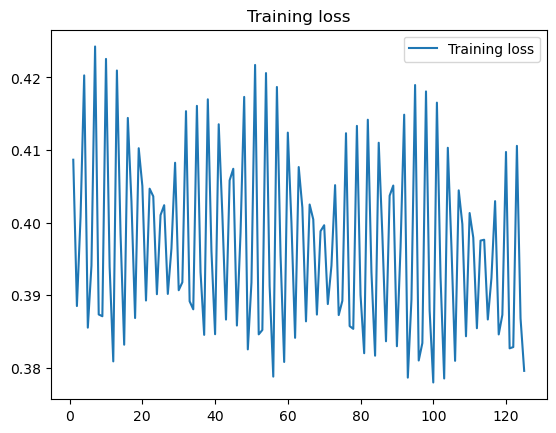

In [12]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

### 测试集预测

In [13]:
# 忘记enumerate的功能呢你就看看这个，他的功能是得到一个序号表
labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rp-ann', 'rp-data']
for i, label in enumerate(labels):
    print(i, label)

0 rEvp-ann
1 rEvp-data
2 rX-ann
3 rX-data
4 rp-ann
5 rp-data


In [14]:
def my_generator():
    yield 1
    yield 2
    yield 3

这个是解决底下那个bug的关键↓↓↓,这个generator函数每次都会执行到yield然后自动中断，下一次再调用的时候又从yield开始运行，目的是在不加载整个数据集的情况下提取出数据，因为每次运行到yield就会终止，所以就算是很大的数据集（可以看成是无限循环），也只需要在适当条件下插入yield语句就可以终止。这不禁让我陷入沉思：我这一共不到五千的数据集，真的有必要整的这么花里胡哨用generator函数提取数据吗o.0？

In [15]:
gen = my_generator()
for v in gen:
    print(v)

1
2
3


In [14]:
import matplotlib.pyplot as plt

pre = model.predict(test_gen, batch_size=128, steps=val_steps)
print(pre)
print(pre.shape)

index = range(len(pre))
# 预测值
pred = pre * std[4:] + mean[4:]
# 真实值
test_targets = []
for values in test_gen:
    test_targets.append(values)
target_tsd = test_targets * std[4:] + mean[4:] # ########################### 这条有bug，问题是不知道怎么把test_gen里的targets数据整出来 ########################### #

labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rp-ann', 'rp-data']
for i, label in enumerate(labels):
    plt.plot(pred[index, i // 2], label=label)
    plt.plot(target_tsd[index, i // 2], label=label)
    plt.xlabel('timesteps')
    plt.legend()
plt.show()   

19/19 [==============================] - 0s 3ms/step
[[ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 ...
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]]
(608, 3)


MemoryError: Unable to allocate 375. KiB for an array with shape (32, 375, 4) and data type float64

MemoryError: Unable to allocate 375. KiB for an array with shape (32, 375, 4) and data type float64，这种神奇的报错是为什么呢？我思考了一下或许是因为for value in test_gen会无限循环调用数据生成器：test_gen，当调取了数据已经装载到375kb时，单变量存储量溢出。。。

## 保存模型

In [16]:
# save the structure and weight
model.save('model1d.h5')

del model

# recover the structure and weight
model = model.load_model('model1d.h5')
model.evaculate(test_gen)

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'model' is not defined

# K折验证
将数据集划分为训练集和验证集。数据少时验证集小，验证分数可能会有很大的波动，数值上表现为验证分数方差很大，这时采用K折交叉验证把数据划分为K个分区，实例化K-1个相同模型，将每个模型在K-1个分区上训练，并在剩下一个分区上评估。最终的模型验证分数取K个验证分数的平均值

## 单独划分数据集
因为上面的模型精度有些不自然，考虑到可能是数据量太小的问题，这里采用K折验证处理模型，因此不用generator函数划分数据集，而单独采用sklearn的train_test_split模块，注意，这里使用的数据应当已经标准化。

In [17]:
# from sklearn import datasets    # 这是个导入sklearn自建数据库的代码，此处没用
from sklearn.model_selection import train_test_split

# 划分数据
X = float_data[:, :4]
Y = float_data[:, 4:]

# 将原始数据划分为训练集和测试集
train_data, test_data, train_targets, test_targets = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=6)    # 注意，该函数有一个参数shuffle默认值为true，意味着取数据集时是默认打乱了来取的
train_data.shape, train_targets.shape

((2400, 4), (2400, 3))

## 模型定义
all used models will be defined here.

In [18]:
# 模型定义1
from keras import models
from keras import layers

def build_model1():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(3))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

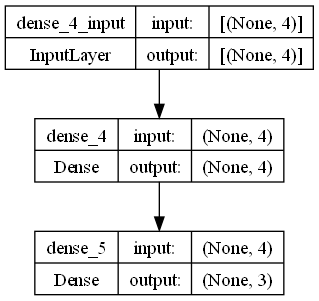

In [26]:
utils.plot_model(build_model1(), to_file='dense43.png', show_shapes=True)

In [19]:
# 模型定义2
from keras import models
from keras import layers
from keras.optimizers import RMSprop

def build_model2():
    model = models.Sequential()
    model.add(layers.GRU(10, return_sequences=True, input_shape=(None, train_data.shape[-1])))
    model.add(layers.Dense(3))
    model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

## K折验证

In [20]:
# K折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model1()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
all_scores

[0.6560092568397522,
 0.3914792835712433,
 0.2674054503440857,
 0.2508294880390167]

In [22]:
np.mean(all_scores)

0.3914308696985245

## 增大epoch观察模型表现
从model1的4折验证结果来看，验证分数差异略大，分布在0.2到0.36之间，平均分数0.28意味着预测应力率[rEvp, rX, rp]和实际应力率相差0.28Mpa

2023.8.28计算结果

In [23]:

from keras import models
from keras import layers
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model1()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [24]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 绘制验证分数

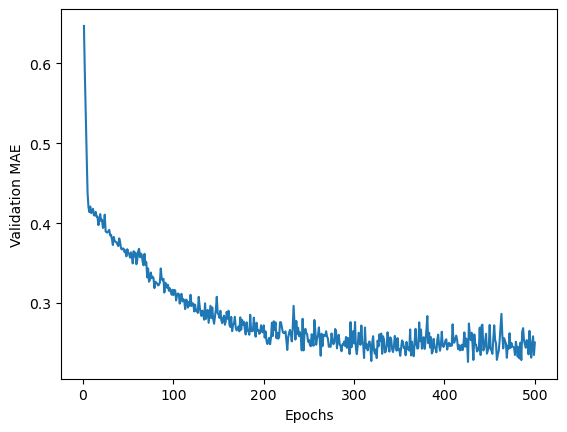

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 重绘验证分数
①删除前10个数据点，因为这些点取值与其他点不同 ②将每个数据点替换为前面数据点的指数移动平均值。 可以观察到MAE在80轮以后就不再降低，之后

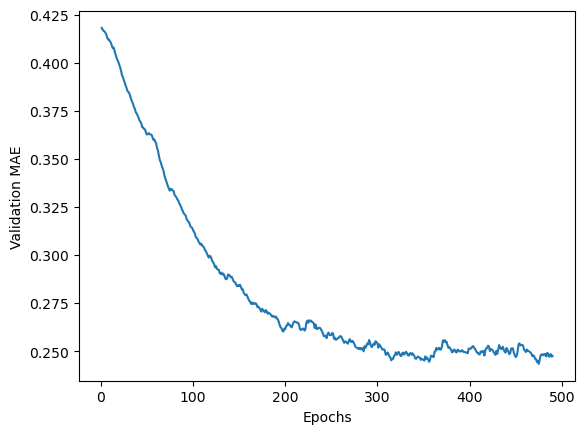

In [26]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

再找到曲线最低点的epoch值

In [27]:
# 找到最小值的索引
min_index = smooth_mae_history.index(min(smooth_mae_history))

# 打印最小值的索引
print("最小值的索引:", min_index)

最小值的索引: 474


## 训练最终模型1

In [28]:
model = build_model1()
print(model.metrics_names)
model.fit(train_data, train_targets, epochs=474, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

[]
19/19 [==============================] - 0s 776us/step - loss: 0.0496 - mae: 0.1337


In [29]:
# 测试集结果如下
test_mae_score
predictions = model.predict(test_data, batch_size=32, verbose=1)
print(predictions)
print(predictions.shape)

19/19 [==============================] - 0s 728us/step
[[ 1.378042    0.9706068   1.0076168 ]
 [ 1.3819181   0.96580863  1.0131154 ]
 [ 1.3857688   0.9611006   1.0185804 ]
 ...
 [-0.09620869  0.22694409 -1.1653636 ]
 [-0.0967548   0.23151827 -1.1660949 ]
 [-0.09730095  0.23609269 -1.1668262 ]]
(600, 3)


In [33]:
dolm = []
dolm = np.linspace(0, 80, 3000)

for i in dolm:
    print(i)

0.0
0.026675558519506502
0.053351117039013005
0.0800266755585195
0.10670223407802601
0.13337779259753252
0.160053351117039
0.1867289096365455
0.21340446815605202
0.24008002667555853
0.26675558519506504
0.2934311437145715
0.320106702234078
0.34678226075358454
0.373457819273091
0.40013337779259756
0.42680893631210404
0.4534844948316105
0.48016005335111706
0.5068356118706235
0.5335111703901301
0.5601867289096365
0.586862287429143
0.6135378459486496
0.640213404468156
0.6668889629876625
0.6935645215071691
0.7202400800266756
0.746915638546182
0.7735911970656886
0.8002667555851951
0.8269423141047015
0.8536178726242081
0.8802934311437146
0.906968989663221
0.9336445481827276
0.9603201067022341
0.9869956652217405
1.013671223741247
1.0403467822607535
1.0670223407802601
1.0936978992997666
1.120373457819273
1.1470490163387796
1.173724574858286
1.2004001333777925
1.2270756918972991
1.2537512504168056
1.280426808936312
1.3071023674558186
1.333777925975325
1.3604534844948317
1.3871290430143381
1.41380

看不到变量表我真的受不了了，赶紧想办法整一个出来，不然都不知道运行的是多少。。。

range()函数的运行结果给我一些提示，可能下面的绘制结果的函数根本就没有正确运行。。。因此在这个基础上要重新检查一遍绘制结果的正确性

## 绘制结果

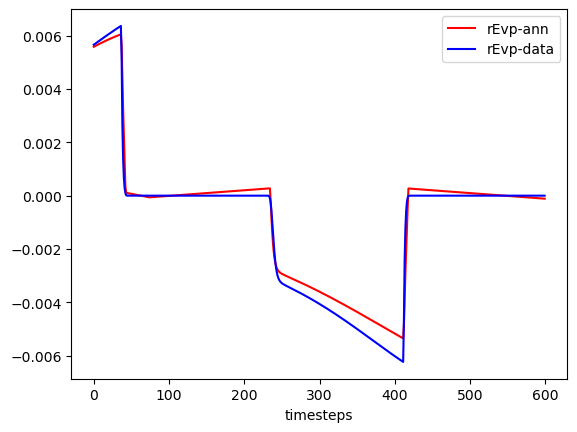

In [30]:
# 绘制结果
import matplotlib.pyplot as plt

index = range(len(predictions))
predictions = predictions * std[4:] + mean[4:]
test_targets = test_targets * std[4:] + mean[4:]

plt.plot(index, predictions[index, 0], 'r', label='rEvp-ann')
plt.plot(index, test_targets[index, 0], 'b', label='rEvp-data')
plt.xlabel('timesteps')
plt.ylabel('')

plt.legend()
plt.show()                                                                              

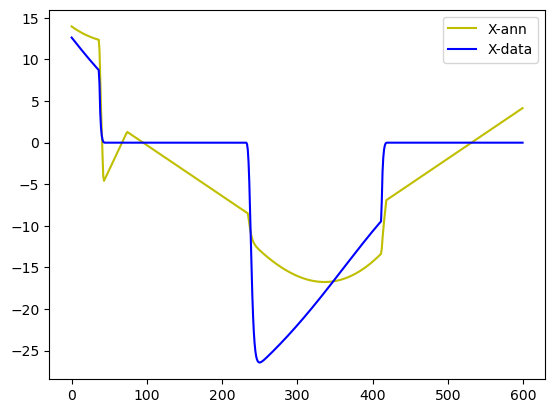

In [31]:
plt.plot(index, predictions[index, 1], 'y', label='X-ann')
plt.plot(index, test_targets[index, 1], 'b', label='X-data')

plt.legend()
plt.show()  

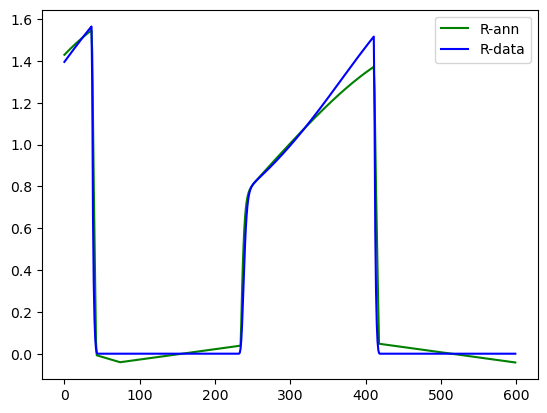

In [32]:
plt.plot(index, predictions[index, 2], 'g', label='R-ann')
plt.plot(index, test_targets[index, 2], 'b', label='R-data')

plt.legend()
plt.show()  

上面三个预测值已经去标准化，因此可以直接通过dR/dt = Rr, 得到R的值应为Rr * t, 目前可以知道采样间隔为80/3000s, 因此就把节点序号乘以采样间隔就可以得到该时刻的时间t, 再乘上Rr得到R, t使用linspace得出来的，但是直接使用range函数会得到不含最后一个元素的序列，目前的报错是有一个超出索引范围的值

In [56]:
Evp1 = [0]
X1 = [0]
R1 = [50]
Evpt1 = [0]  
Xt1 = [0]
Rt1 = [50]
for i in index:
    Evp1.append(predictions[i, 0] * 80 / 3000 * (i + 1))
    X1.append(predictions[i, 1] * 80 / 3000 * (i + 1))
    R1.append(predictions[i, 2] * 80 / 3000 * (i +1))
    
    Evpt1.append(test_targets[i, 0] * 80 / 3000 * (i + 1))
    Xt1.append(test_targets[i, 1] * 80 / 3000 * (i + 1))
    Rt1.append(test_targets[i, 2] * 80 / 3000 * (i + 1))

IndexError: index 600 is out of bounds for axis 0 with size 600

In [ ]:
plt.plot(index, Evp1, 'r', label='rEvp-ann')
plt.plot(index, test25_real[index, 0], 'b', label='rEvp-data')
plt.xlabel('timesteps')

plt.legend()
plt.show()  

## 25预测

94/94 [==============================] - 0s 643us/step
[[-0.07162261  0.10398245 -1.1115867 ]
 [-0.07211098  0.10794364 -1.111795  ]
 [-0.07259938  0.11190477 -1.1120032 ]
 ...
 [-0.13122392  0.45853406 -1.1620133 ]
 [-0.13171229  0.46249527 -1.1622216 ]
 [-0.13220069  0.4664564  -1.1624298 ]]
(3000, 3)


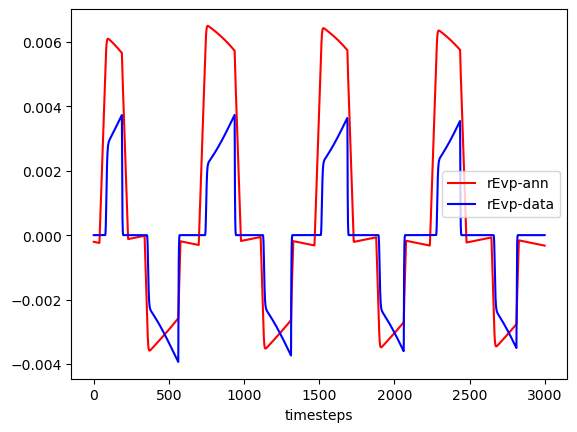

In [34]:
# 25预测
predictions25 = model.predict(testd1, batch_size=32, verbose=1)
print(predictions25)
print(predictions25.shape)

index = range(len(predictions25))
test25_predict = scaler.inverse_transform(predictions25)
test25_real = scaler.inverse_transform(targetsd1)

plt.plot(index, test25_predict[index, 0], 'r', label='rEvp-ann')
plt.plot(index, test25_real[index, 0], 'b', label='rEvp-data')
plt.xlabel('timesteps')

plt.legend()
plt.show()    

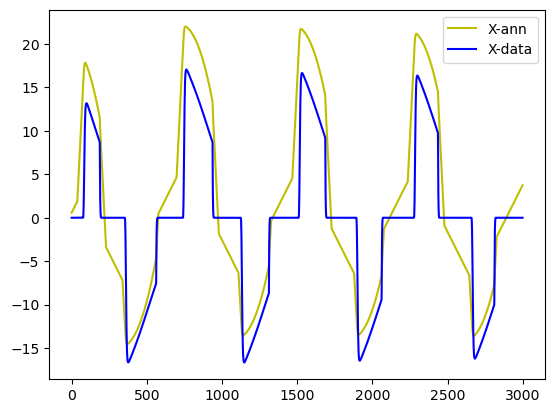

In [35]:
plt.plot(index, test25_predict[index, 1], 'y', label='X-ann')
plt.plot(index, test25_real[index, 1], 'b', label='X-data')

plt.legend()
plt.show()  

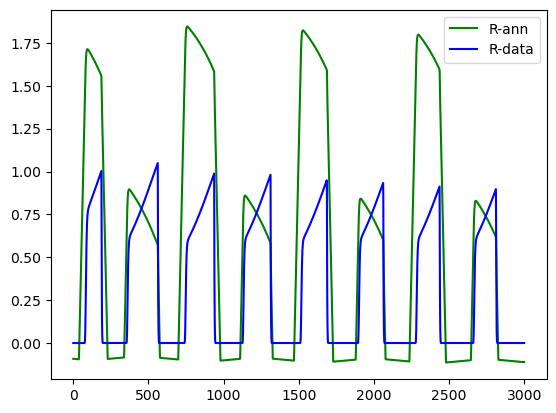

In [36]:
plt.plot(index, test25_predict[index, 2], 'g', label='R-ann')
plt.plot(index, test25_real[index, 2], 'b', label='R-data')

plt.legend()
plt.show()  

In [ ]:
plt.plot(index, test25_predict[index, 2], 'g', label='R-ann')

## K fold validation for model2

In [37]:
# 模型定义2
from keras import models
from keras import layers
from keras.optimizers import RMSprop

def build_model2():
    model = models.Sequential()
    model.add(layers.GRU(10, return_sequences=True, input_shape=(None, train_data.shape[-1])))
    model.add(layers.Dense(3))
    model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

In [38]:
# K折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model2()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
print(all_scores, np.mean(all_scores))

processing fold # 0


ValueError: in user code:

    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_10' (type Sequential).
    
    Input 0 of layer "gru" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (1, 4)
    
    Call arguments received by layer 'sequential_10' (type Sequential):
      • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
      • training=True
      • mask=None


## 根据得分增大epoch

In [13]:
from keras import models
from keras import layers

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model1()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## 绘制验证分数

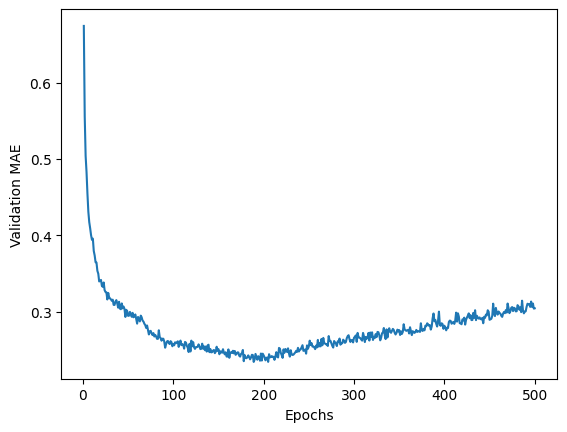

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 重绘验证分数

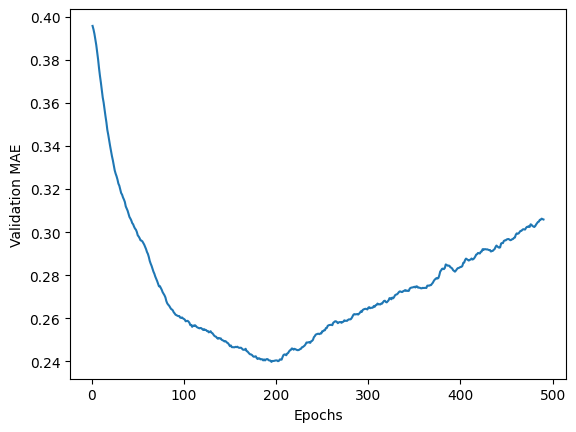

In [16]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 最终模型

In [17]:
model = build_model1()
print(model.metrics_names)
model.fit(train_data, train_targets, epochs=200, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

[]
19/19 [==============================] - 0s 5ms/step - loss: 0.0868 - mae: 0.1789


## 测试集结果

In [18]:
# 测试集结果如下
test_mae_score
predictions = model.predict(test_data, batch_size=32, verbose=1)
print(predictions)
print(predictions.shape)

19/19 [==============================] - 0s 3ms/step
[[ 1.3115643   0.6196024   0.834029  ]
 [ 1.3137611   0.6063037   0.83526665]
 [ 1.315912    0.59294605  0.8364361 ]
 ...
 [-0.07557162  0.561979   -1.0474048 ]
 [-0.07568205  0.5674405  -1.0464385 ]
 [-0.07579248  0.57290196 -1.0454721 ]]
(600, 3)


In [ ]:
# 结果图绘制
import matplotlib.pyplot as plt

index = range(len(predictions))
predictions = predictions * std[4:] + mean[4:]
test_targets = test_targets * std[4:] + mean[4:]

labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rp-ann', 'rp-data']
for i, label in enumerate(labels)
    plt.plot(predictions[index, i // 2], label=label)
    plt.plot(test_targets[index, i // 2], label=label)
    plt.xlabel('timesteps')
    plt.legend()
plt.show()   